## R을 이용한 m텍스트 마이닝
## 백영민 / 한울아카데미

########################################
#제 3부 텍스트 데이터 분석 및 결과제시##
#02 토픽모형############################
########################################

### LDA를 시작하기 이전에, 다음의 문헌이 어렵더라도 3-4번 정도 훑어보기 바란다.
### Blei, D. M., Ng, A. Y., & Jordan, M. I. (2003). Latent dirichlet allocation. 
### Journal of machine Learning research, 3, 993-1022.

In [3]:
# prepare dtm.e

library(stringr)
library('tm')
#모아놓은 텍스트 자료의 화일 위치를 설정합니다. 
#2009년부터 2015년까지 백영민의 출간논문 초록의 말뭉치를 구성합니다. 
my.text.location <- "ymbaek_papers"
mypaper  <- VCorpus(DirSource(my.text.location))
#말뭉치를 검토해 봅시다
mypaper
summary(mypaper)

#말뭉치를 구성하는 두 번째 문서는?
mypaper[[2]]

#말뭉치를 구성하는 두 번째 문서의 내용은? 
mypaper[[2]]$content

#말뭉치를 구성하는 두 번째 문서의 메타데이터는? 
mypaper[[2]]$meta

#메타데이터 입력
meta(mypaper[[2]],tag='author') <- 'Y. M. Baek'
meta(mypaper[[2]])

#다음과 방식을 사용하면 특수기호 사용 전후의 단어들이 무엇인지 살펴볼 수 있다.
myfunc <- function(x) {str_extract_all(x,"[[:alnum:]]{1,}[[:punct:]]{1}?[[:alnum:]]{1,}")}
mypuncts <- lapply(mypaper, myfunc)
table(unlist(mypuncts))

#다음과 방식을 사용하면 수치로 표시된 자료가 어떤 것인지 살펴볼 수 있다. 
myfunc <- function(x) {str_extract_all(x,"[[:digit:]]{1,}")}
mydigits <- lapply(mypaper, myfunc)
table(unlist(mydigits))

#다음과 방식을 사용하면 대문자로 시작하는 단어를 확인할 수 있다(고유명사 확인에 유용함)
myfunc <- function(x) {str_extract_all(x,"[[:upper:]]{1}[[:alpha:]]{1,}")}
myuppers <- lapply(mypaper, myfunc)
table(unlist(myuppers))

#우선 숫자표현들을 모두 삭제하였다. 
mycorpus <- tm_map(mypaper, removeNumbers)

#다음으로 특수문자가 들어간 표현들 중 하나의 단어로 취급되어야 하는 것들을 처리하였다.
#removePunctuation의 경우 텍스트 성격을 고려한 아래의 사항들을 반영하지 못한다.
mytempfunc <- function(myobject,oldexp,newexp){
newobject <- tm_map(myobject,
content_transformer(function(x, pattern) gsub(pattern, newexp, x)), oldexp)
newobject
}
mycorpus <- mytempfunc(mycorpus,"-collar","collar")
mycorpus <- mytempfunc(mycorpus,"\\b((c|C)o-)","co")
mycorpus <- mytempfunc(mycorpus,"\\b((c|C)ross-)","cross")
mycorpus <- mytempfunc(mycorpus,"e\\.g\\.","for example")
mycorpus <- mytempfunc(mycorpus,"i\\.e\\.","that is")
mycorpus <- mytempfunc(mycorpus,"\\'s","")
mycorpus <- mytempfunc(mycorpus,"s’","s")
mycorpus <- mytempfunc(mycorpus,"ICD-","ICD")
mycorpus <- mytempfunc(mycorpus,"\\b((i|I)nter-)","inter")
mycorpus <- mytempfunc(mycorpus,"K-pop","Kpop")
mycorpus <- mytempfunc(mycorpus,"\\b((m|M)eta-)","meta")
mycorpus <- mytempfunc(mycorpus,"\\b((o|O)pt-)","opt")
mycorpus <- mytempfunc(mycorpus,"\\b((p|P)ost-)","post")
mycorpus <- mytempfunc(mycorpus,"-end","end")
mycorpus <- mytempfunc(mycorpus,"\\b((w|W)ithin-)","within")
mycorpus <- mytempfunc(mycorpus,"=","is equal to")
mycorpus <- mytempfunc(mycorpus,"and/or","and or")
mycorpus <- mytempfunc(mycorpus,"his/her","his her")
mycorpus <- mytempfunc(mycorpus,"-"," ")

#나머지 특수문자들은 공란으로 처리하여 제거하였다. 
#removePunctuation의 경우 and/oR을 and or로 바꾸지 않고, andor로 바꾸는 등 여기서는 문제가 적지 않다. 
mycorpus <- tm_map(mycorpus, removePunctuation)

#공란처리과정 
mycorpus <- tm_map(mycorpus, stripWhitespace)

#대소문자를 통합하였다. 
mycorpus <- tm_map(mycorpus, content_transformer(tolower))

#불용단어들 삭제(SMART 목록 사용)
mycorpus <- tm_map(mycorpus, removeWords, words=stopwords("SMART"))

#스테밍(어근동일화) 처리하였다. 
mycorpus <- tm_map(mycorpus, stemDocument, language="en")

#우선 문자수와 단어수를 계산하기 위한 개인맞춤형 함수 설정
mycharfunc <- function(x) {str_extract_all(x,".")}
mywordfunc <- function(x) {str_extract_all(x,boundary("word"))}
#사전처리과정 적용이전
mychar <- lapply(mypaper, mycharfunc)
myuniquechar0 <- length(table(unlist(mychar)))
mytotalchar0 <- sum(table(unlist(mychar)))
myword <- lapply(mypaper, mywordfunc)
myuniqueword0 <- length(table(unlist(myword)))
mytotalword0 <- sum(table(unlist(myword)))

#사전처리과정 적용이후
mychar <- lapply(mycorpus, mycharfunc)
myuniquechar1 <- length(table(unlist(mychar)))
mytotalchar1 <- sum(table(unlist(mychar)))
myword <- lapply(mycorpus, mywordfunc)
myuniqueword1 <- length(table(unlist(myword)))
mytotalword1 <- sum(table(unlist(myword)))

#사전처리로 인해 어떻게 변화했는지를 살펴보자. 
results.comparing <- rbind(
  c(myuniquechar0,myuniquechar1),
  c(mytotalchar0,mytotalchar1),
  c(myuniqueword0,myuniqueword1),
  c(mytotalword0,mytotalword1))
colnames(results.comparing) <- c("before","after")
rownames(results.comparing) <- c("고유문자수","총문자수","고유단어수","총단어수")
results.comparing

#이제 문서X단어행렬을 구축하자.
#TermDocumentMatrix를 사용하면 가로줄에는 단어가, 세로줄에는 문서가 배치된다. 
dtm.e <- DocumentTermMatrix(mycorpus) 


<<VCorpus>>
Metadata:  corpus specific: 0, document level (indexed): 0
Content:  documents: 24

           Length Class             Mode
p2009a.txt 2      PlainTextDocument list
p2009b.txt 2      PlainTextDocument list
p2010a.txt 2      PlainTextDocument list
p2010b.txt 2      PlainTextDocument list
p2010c.txt 2      PlainTextDocument list
p2011a.txt 2      PlainTextDocument list
p2011b.txt 2      PlainTextDocument list
p2012a.txt 2      PlainTextDocument list
p2012b.txt 2      PlainTextDocument list
p2013a.txt 2      PlainTextDocument list
p2014a.txt 2      PlainTextDocument list
p2014b.txt 2      PlainTextDocument list
p2014c.txt 2      PlainTextDocument list
p2014d.txt 2      PlainTextDocument list
p2014e.txt 2      PlainTextDocument list
p2014f.txt 2      PlainTextDocument list
p2014g.txt 2      PlainTextDocument list
p2014h.txt 2      PlainTextDocument list
p2014i.txt 2      PlainTextDocument list
p2014k.txt 2      PlainTextDocument list
p2015a.txt 2      PlainTextDocument list
p2015b.txt 2      PlainTextDocument list
p2015c.txt 2      PlainTextDocument list
p2015d.txt 2    

<<PlainTextDocument>>
Metadata:  7
Content:  chars: 990

[1] "The debate on late night comedy has been inconclusive, with some scholars arguing that this genre increases political knowledge, and others seeing late night comedy as harmful to effective citizenry. We add to the debate and to the research on media effects more generally, by proposing a model that measures political knowledge. The model utilizes item response theory (IRT) to account for individual characteristics, knowledge item difficulty, and response format that influences the likelihood of providing a correct response. Drawing on the 2004 National Annenberg Election Study, we employ this model to test knowledge gain from late night comedy. Using a meta-analysis across 35 political knowledge items, we show that late night comedy increases knowledge, but primarily on easy political items that have fewer correct response options, and mainly among the inattentive citizens. We discuss theoretical implications and provide practical suggestions for scholarship on media effects."

  author       : character(0)
  datetimestamp: 2019-05-07 12:37:18
  description  : character(0)
  heading      : character(0)
  id           : p2009b.txt
  language     : en
  origin       : character(0)

  author       : Y. M. Baek
  datetimestamp: 2019-05-07 12:37:18
  description  : character(0)
  heading      : character(0)
  id           : p2009b.txt
  language     : en
  origin       : character(0)

Warning message in stri_extract_all_regex(string, pattern, simplify = simplify, :
“argument is not an atomic vector; coercing”Warning message in stri_extract_all_regex(string, pattern, simplify = simplify, :
“argument is not an atomic vector; coercing”Warning message in stri_extract_all_regex(string, pattern, simplify = simplify, :
“argument is not an atomic vector; coercing”Warning message in stri_extract_all_regex(string, pattern, simplify = simplify, :
“argument is not an atomic vector; coercing”Warning message in stri_extract_all_regex(string, pattern, simplify = simplify, :
“argument is not an atomic vector; coercing”Warning message in stri_extract_all_regex(string, pattern, simplify = simplify, :
“argument is not an atomic vector; coercing”Warning message in stri_extract_all_regex(string, pattern, simplify = simplify, :
“argument is not an atomic vector; coercing”Warning message in stri_extract_all_regex(string, pattern, simplify = simplify, :
“argument is not an atomic vector; c


             and/or  anxious-ambivalent         blue-collar       co-activation 
                  2                   1                   1                   1 
      co-constraint        co-emergence        co-existence     content-analyze 
                  1                   1                   1                   1 
     cross-cultural    cross-culturally         cross-party    culture-specific 
                  6                   1                   1                   1 
        data-driven dismissive-avoidant                 e.g       export/import 
                  1                   1                   3                   1 
       eye-oriented             face-to    fearful-avoidant    five-dimensional 
                  1                   6                   1                   1 
          follow-up         Gudykunst's             his/her          Hofstede's 
                  3                   1                   1                   2 
                i.e        

Warning message in stri_extract_all_regex(string, pattern, simplify = simplify, :
“argument is not an atomic vector; coercing”Warning message in stri_extract_all_regex(string, pattern, simplify = simplify, :
“argument is not an atomic vector; coercing”Warning message in stri_extract_all_regex(string, pattern, simplify = simplify, :
“argument is not an atomic vector; coercing”Warning message in stri_extract_all_regex(string, pattern, simplify = simplify, :
“argument is not an atomic vector; coercing”Warning message in stri_extract_all_regex(string, pattern, simplify = simplify, :
“argument is not an atomic vector; coercing”Warning message in stri_extract_all_regex(string, pattern, simplify = simplify, :
“argument is not an atomic vector; coercing”Warning message in stri_extract_all_regex(string, pattern, simplify = simplify, :
“argument is not an atomic vector; coercing”Warning message in stri_extract_all_regex(string, pattern, simplify = simplify, :
“argument is not an atomic vector; c


   0    1   11 1973    2 2002 2003 2004 2007 2008 2012 2028    3   35    4  712 
   1   35    1    1    9    1    1    1    1    2    2    1    7    1    2    1 
 756   78   82    9 
   1    1    1    1 

Warning message in stri_extract_all_regex(string, pattern, simplify = simplify, :
“argument is not an atomic vector; coercing”Warning message in stri_extract_all_regex(string, pattern, simplify = simplify, :
“argument is not an atomic vector; coercing”Warning message in stri_extract_all_regex(string, pattern, simplify = simplify, :
“argument is not an atomic vector; coercing”Warning message in stri_extract_all_regex(string, pattern, simplify = simplify, :
“argument is not an atomic vector; coercing”Warning message in stri_extract_all_regex(string, pattern, simplify = simplify, :
“argument is not an atomic vector; coercing”Warning message in stri_extract_all_regex(string, pattern, simplify = simplify, :
“argument is not an atomic vector; coercing”Warning message in stri_extract_all_regex(string, pattern, simplify = simplify, :
“argument is not an atomic vector; coercing”Warning message in stri_extract_all_regex(string, pattern, simplify = simplify, :
“argument is not an atomic vector; c


     Abstract        Action  Additionally     Affective   Affirmative 
            1             1             1             3             1 
      African          AIMS      Although   Ambivalence      American 
            1             1             2             1             1 
    Americans            An           AND         Anger     Annenberg 
            2             1             1             1             1 
  Application Approximately           Are            As        Asians 
            1             1             1             1             1 
           At    BACKGROUND          Bank        Barack         Based 
            1             1             1             1             5 
       Benoit         Black          Both            By   CONCLUSIONS 
            1             4             1             5             1 
          CVC          Data    Democratic     Democrats    Depression 
            1             1             1             4             2 
     

Warning message in stri_extract_all_regex(string, pattern, simplify = simplify, :
“argument is not an atomic vector; coercing”Warning message in stri_extract_all_regex(string, pattern, simplify = simplify, :
“argument is not an atomic vector; coercing”Warning message in stri_extract_all_regex(string, pattern, simplify = simplify, :
“argument is not an atomic vector; coercing”Warning message in stri_extract_all_regex(string, pattern, simplify = simplify, :
“argument is not an atomic vector; coercing”Warning message in stri_extract_all_regex(string, pattern, simplify = simplify, :
“argument is not an atomic vector; coercing”Warning message in stri_extract_all_regex(string, pattern, simplify = simplify, :
“argument is not an atomic vector; coercing”Warning message in stri_extract_all_regex(string, pattern, simplify = simplify, :
“argument is not an atomic vector; coercing”Warning message in stri_extract_all_regex(string, pattern, simplify = simplify, :
“argument is not an atomic vector; c

“argument is not an atomic vector; coercing”Warning message in stri_extract_all_regex(string, pattern, simplify = simplify, :
“argument is not an atomic vector; coercing”Warning message in stri_extract_all_regex(string, pattern, simplify = simplify, :
“argument is not an atomic vector; coercing”Warning message in stri_extract_all_regex(string, pattern, simplify = simplify, :
“argument is not an atomic vector; coercing”Warning message in stri_extract_all_regex(string, pattern, simplify = simplify, :
“argument is not an atomic vector; coercing”Warning message in stri_extract_all_regex(string, pattern, simplify = simplify, :
“argument is not an atomic vector; coercing”Warning message in stri_extract_all_regex(string, pattern, simplify = simplify, :
“argument is not an atomic vector; coercing”Warning message in stri_extract_all_regex(string, pattern, simplify = simplify, :
“argument is not an atomic vector; coercing”Warning message in stri_extract_all_boundaries(string, pattern, simplify =

,before,after
고유문자수,77,27
총문자수,24940,14605
고유단어수,1155,687
총단어수,3556,2045


In [4]:
#영문학술논문 말뭉치에서 5개의 잠재토픽을 추출하자. 
#control=list(seed=11) 옵션을 지정하지 않으면 매번 실행한 결과가 달라진다. 
library('topicmodels')
lda.out <- LDA(dtm.e,control=list(seed=11),k=5)

#아래는 문서X토픽 행렬이다. 
dim(lda.out@gamma)
#아래는 토픽X단 행렬이다. 
dim(lda.out@beta)

#5개의 잠재토픽으로 분류된 상위12개 단어들을 살펴보자. 
terms(lda.out,12)
#순서대로 다음과 같이 이름을 붙여보자. 
#Topic 1=media psychology
#Topic 2=cross-culturalSNS
#Topic 3=SNS
#Topic 4=privacy
#Topic 5=politics

[1] 24  5

[1]   5 686

Topic 1,Topic 2,Topic 3,Topic 4,Topic 5
polit,privaci,cultur,poll,polit
studi,social,studi,face,sns
white,relationship,crosscultur,onlin,studi
black,inform,depress,set,find
democrat,knowledg,effect,deliber,onlin
racial,studi,examin,effect,influenc
action,ambival,adult,model,compar
find,person,condit,affect,particip
vote,effect,consumpt,valenc,style
ideolog,sns,expenditur,opinion,social


In [5]:
#각 문서가 담고있는 잠재토픽의 확률점수를 계산하였다. 
posterior_lda <- posterior(lda.out)
round(posterior_lda$topics,3)

,1,2,3,4,5
p2009a.txt,0.000,0.000,0.000,0.999,0.000
p2009b.txt,0.000,0.999,0.000,0.000,0.000
p2010a.txt,0.000,0.000,0.000,0.181,0.818
p2010b.txt,0.000,0.999,0.000,0.000,0.000
p2010c.txt,0.000,0.000,0.000,0.000,0.999
p2011a.txt,0.999,0.000,0.000,0.000,0.000
p2011b.txt,0.000,0.000,0.000,0.999,0.000
p2012a.txt,0.131,0.000,0.000,0.868,0.000
p2012b.txt,0.999,0.000,0.000,0.000,0.000
p2013a.txt,0.000,0.999,0.000,0.000,0.000


In [6]:
#아래와 같이 향후 분석에 사용할 수 있도록 데이터 프레임으로 저장하였다. 
lda.topics <- data.frame(posterior_lda$topics)
#아래는 문서별 토픽 등장 확률의 총합이다. 
apply(lda.topics,1,sum)

p2009a.txt p2009b.txt p2010a.txt p2010b.txt p2010c.txt p2011a.txt p2011b.txt 
         1          1          1          1          1          1          1 
p2012a.txt p2012b.txt p2013a.txt p2014a.txt p2014b.txt p2014c.txt p2014d.txt 
         1          1          1          1          1          1          1 
p2014e.txt p2014f.txt p2014g.txt p2014h.txt p2014i.txt p2014k.txt p2015a.txt 
         1          1          1          1          1          1          1 
p2015b.txt p2015c.txt p2015d.txt 
         1          1          1

In [7]:
#아래는 문서들 전체에서의 토픽등장 확률의 총합이다. 
apply(lda.topics,2,sum)


X1       X2       X3       X4       X5 
4.132756 4.430464 4.001496 5.406921 6.028363

In [9]:

#년도별로 각각의 잠재토픽이 어떤 변화를 보이는지 살펴보자. 
tempyear <- rownames(lda.topics)
pubyear <- as.numeric(unlist(str_extract_all(tempyear,"[[:digit:]]{4}")))
#아래의 결과를 보면 년도별 잠재토픽 변화패턴을 살펴볼 수 있다.
topic.by.year <- round(aggregate(as.matrix(lda.topics)~pubyear,lda.topics,sum),5)
topic.by.year

pubyear,X1,X2,X3,X4,X5
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2009,0.00059,0.99926,0.00059,0.99898,0.00059
2010,0.00090,0.99947,0.00090,0.18168,1.81705
2011,0.99926,0.00057,0.00057,0.99902,0.00057
2012,1.13032,0.00056,0.00056,0.86800,0.00056
2013,0.00019,0.99925,0.00019,0.00019,0.00019
2014,0.00305,1.43030,2.00029,2.35801,4.20836
2015,1.99845,0.00105,1.99840,0.00105,0.00105



Attaching package: ‘ggplot2’

The following object is masked from ‘package:NLP’:

    annotate



,year,topic_i,score
,<dbl>,<chr>,<dbl>
2009.1,2009,media psychology,0.00059
2010.1,2010,media psychology,0.00090
2011.1,2011,media psychology,0.99926
2012.1,2012,media psychology,1.13032
2013.1,2013,media psychology,0.00019
2014.1,2014,media psychology,0.00305


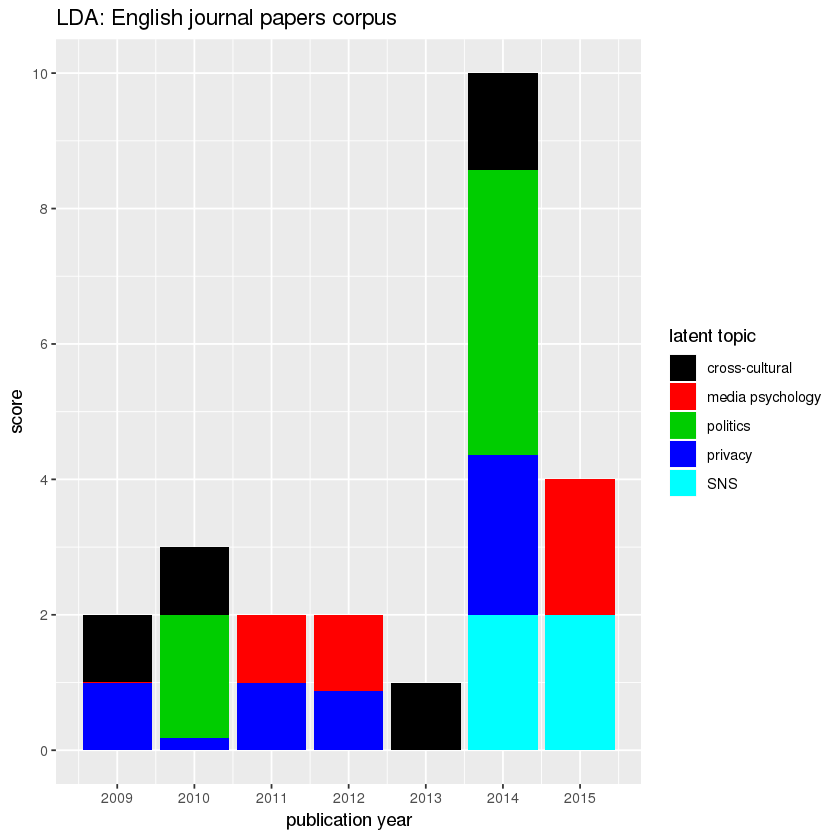

In [10]:
#그래프를 그려보았다. 
library('ggplot2')
topic.by.year <- reshape(topic.by.year, idvar = "pubyear", varying = list(2:6),
                         v.names = "X", direction = "long")
colnames(topic.by.year) <- c('year','topic_i','score')
topic.by.year$topic_i[topic.by.year$topic_i==1] <- 'media psychology'
topic.by.year$topic_i[topic.by.year$topic_i==2] <- 'cross-cultural'
topic.by.year$topic_i[topic.by.year$topic_i==3] <- 'SNS'
topic.by.year$topic_i[topic.by.year$topic_i==4] <- 'privacy'
topic.by.year$topic_i[topic.by.year$topic_i==5] <- 'politics'
head(topic.by.year)

ggplot(data=topic.by.year, aes(x=year, y=score, fill=topic_i)) + 
  geom_bar(stat="identity")+
  scale_x_continuous(breaks=2009:2015,labels=2009:2015)+
  scale_y_continuous(breaks=2*(0:5),labels=2*(0:5))+
  scale_fill_manual(values=1:5)+
  labs(x="publication year",y="score",fill='latent topic')+
  ggtitle("LDA: English journal papers corpus")

In [11]:
#alpha 값이 LDA 결과에 미치는 효과 
#시나리오1
round(posterior(LDA(dtm.e,control=list(seed=11,alpha=10),k=5))$topics,3)

,1,2,3,4,5
p2009a.txt,0.000,0.000,0.000,0.999,0.000
p2009b.txt,0.000,0.999,0.000,0.000,0.000
p2010a.txt,0.000,0.000,0.000,0.181,0.818
p2010b.txt,0.000,0.999,0.000,0.000,0.000
p2010c.txt,0.000,0.000,0.000,0.000,0.999
p2011a.txt,0.999,0.000,0.000,0.000,0.000
p2011b.txt,0.000,0.000,0.000,0.999,0.000
p2012a.txt,0.131,0.000,0.000,0.868,0.000
p2012b.txt,0.999,0.000,0.000,0.000,0.000
p2013a.txt,0.000,0.999,0.000,0.000,0.000


In [12]:

#시나리오2
round(posterior(LDA(dtm.e,control=list(seed=11,alpha=100),k=5))$topics,3)

,1,2,3,4,5
p2009a.txt,0.201,0.202,0.197,0.204,0.197
p2009b.txt,0.199,0.204,0.202,0.194,0.201
p2010a.txt,0.202,0.196,0.201,0.199,0.202
p2010b.txt,0.198,0.204,0.198,0.197,0.202
p2010c.txt,0.202,0.196,0.200,0.198,0.204
p2011a.txt,0.209,0.200,0.197,0.196,0.198
p2011b.txt,0.201,0.198,0.199,0.205,0.197
p2012a.txt,0.201,0.200,0.199,0.202,0.198
p2012b.txt,0.204,0.195,0.202,0.196,0.203
p2013a.txt,0.197,0.209,0.193,0.200,0.200


In [13]:
#우선 LDA와 마찬가지로 5개의 잠재토픽을 추정하고, 상위 12개까지의 단어들을 점검한다. 
ctm.out <- CTM(dtm.e,control=list(seed=44),k=5)
terms(ctm.out,12)
# Topic 1=politics
# Topic 2=cross-cultural
# Topic 3=privacy
# Topic 4=media psychology
# Topic 5=SNS 

Topic 1,Topic 2,Topic 3,Topic 4,Topic 5
privaci,sns,cultur,polit,racial
onlin,social,studi,cultur,action
studi,studi,knowledg,onlin,studi
inform,relationship,onlin,face,effect
polit,effect,optim,set,support
frame,poll,privaci,studi,nonblack
valenc,ambival,compar,trust,stereotyp
white,polit,discuss,deliber,tendenc
opinion,depress,implic,particip,negat
person,condit,perceiv,model,find


In [14]:
#잠재토픽과 단어들에 부여된 가중치를 살펴보고, 문서별 잠재토픽의 확률을 점검하였다. 
posterior_ctm <- posterior(ctm.out)
ctm.topics <- data.frame(posterior_ctm$topics)
round(ctm.topics,3)

,X1,X2,X3,X4,X5
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
p2009a.txt,0.000,0.000,0.000,0.995,0.005
p2009b.txt,0.000,0.000,0.995,0.000,0.005
p2010a.txt,0.000,0.057,0.000,0.935,0.008
p2010b.txt,0.000,0.996,0.000,0.000,0.004
p2010c.txt,0.000,0.000,0.000,0.995,0.005
p2011a.txt,0.994,0.000,0.000,0.000,0.005
p2011b.txt,0.996,0.000,0.000,0.000,0.004
p2012a.txt,0.000,0.000,0.000,0.980,0.020
p2012b.txt,0.001,0.001,0.001,0.001,0.996


In [15]:
#년도에 따라 CTM으로 분류한 잠재토픽의 변화를 살펴보았다. 
tempyear <- rownames(ctm.topics)
pubyear <- as.numeric(unlist(str_extract_all(tempyear,"[[:digit:]]{4}")))
topic.by.year <- round(aggregate(as.matrix(ctm.topics)~pubyear,ctm.topics,sum),3)
topic.by.year

topic.by.year <- reshape(topic.by.year, idvar = "pubyear", varying = list(2:6),
                         v.names = "X", direction = "long")
colnames(topic.by.year) <- c('year','topic_i','score')
topic.by.year$topic_i[topic.by.year$topic_i==1] <- 'politics'
topic.by.year$topic_i[topic.by.year$topic_i==2] <- 'cross-cultural'
topic.by.year$topic_i[topic.by.year$topic_i==3] <- 'privacy'
topic.by.year$topic_i[topic.by.year$topic_i==4] <- 'media psychology'
topic.by.year$topic_i[topic.by.year$topic_i==5] <- 'SNS'

pubyear,X1,X2,X3,X4,X5
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2009,0.000,0.000,0.995,0.995,0.011
2010,0.000,1.053,0.000,1.930,0.016
2011,1.990,0.000,0.000,0.000,0.009
2012,0.001,0.001,0.001,0.981,1.016
2013,0.000,0.997,0.000,0.000,0.003
2014,1.992,3.981,1.989,1.988,0.050
2015,0.997,0.001,0.996,0.998,1.009


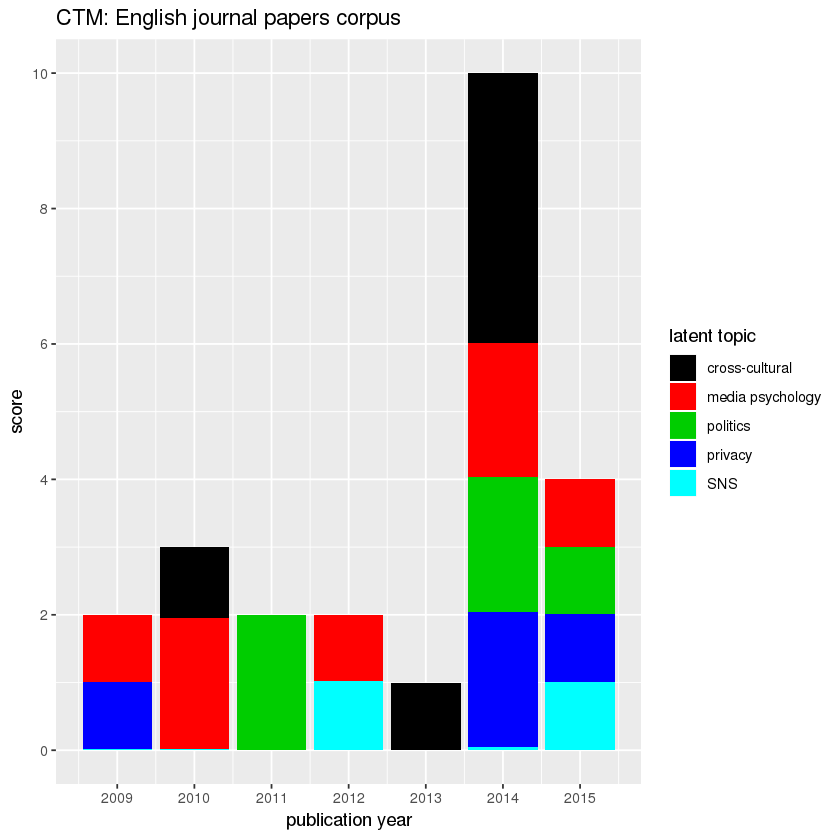

In [16]:
#시간에 따른 변화를 살펴보자. 
ggplot(data=topic.by.year, aes(x=year, y=score, fill=topic_i)) + 
  geom_bar(stat="identity")+
  scale_x_continuous(breaks=2009:2015,labels=2009:2015)+
  scale_y_continuous(breaks=2*(0:5),labels=2*(0:5))+  
  scale_fill_manual(values=1:5)+
  labs(x="publication year",y="score",fill='latent topic')+
  ggtitle("CTM: English journal papers corpus")

In [17]:
#LDA와 CTM의 추정결과의 label을 통일시켜 보자. 
myctmclass <- myldaclass <- rep(NA,24)
myldaclass[as.vector(topics(lda.out))==1] <- 'media psy'
myldaclass[as.vector(topics(lda.out))==2] <- 'cross-cultural'
myldaclass[as.vector(topics(lda.out))==3] <- 'SNS'
myldaclass[as.vector(topics(lda.out))==4] <- 'privacy'
myldaclass[as.vector(topics(lda.out))==5] <- 'politics'
myctmclass[as.vector(topics(ctm.out))==1] <- 'politics'
myctmclass[as.vector(topics(ctm.out))==2] <- 'cross-cultural'
myctmclass[as.vector(topics(ctm.out))==3] <- 'Privacy'
myctmclass[as.vector(topics(ctm.out))==4] <- 'media psy'
myctmclass[as.vector(topics(ctm.out))==5] <- 'SNS'

In [18]:
#교차표를 그리면 아래와 같다. 
as.matrix(table(myldaclass,myctmclass))

                myctmclass
myldaclass       cross-cultural media psy politics Privacy SNS
  cross-cultural              2         0        1       1   0
  media psy                   0         0        2       0   2
  politics                    2         3        0       1   0
  privacy                     1         3        2       0   0
  SNS                         1         1        0       2   0

In [19]:
#코더간 신뢰도 크리펜도르프의 알파를 구하면 아래와 같다. 
library("irr")
lda.vs.ctm <- as.matrix(rbind(as.factor(myldaclass),as.factor(myctmclass)))
kripp.alpha(lda.vs.ctm)

Loading required package: lpSolve


 Krippendorff's alpha

 Subjects = 24 
   Raters = 2 
    alpha = -0.133 

In [21]:
##############################
# dtm.k 구하기
##############################

#R을 이용한 한국어 자연어처리
library('KoNLP')
library('tm')
library('stringr')
#자바의 문제가 있을 수 있으며, 문제발생시 자신의 PC 사양에 맞는 자바를 설치하고 재실행. 

#2016년까지 출간된 저자의 한국어 논문들의 말뭉치를 구성하였다.
mytextlocation <- "ymbaek_nonmun"
mypaper <- VCorpus(DirSource(mytextlocation))
mypaper

#우선 가장 최근 논문초록을 대상으로 한국어 자연어 처리를 진행해 보자. 
mykorean <- mypaper[[19]]$content
mykorean

#간단한 사전처리를 실시하여 봅시다. 
#영문표현들은 모두 삭제하였다(한국어 분석이기 때문에)
mytext <- str_replace_all(mykorean, "[[:lower:]]","")
#괄호를 삭제하였다. 
mytext <- str_replace_all(mytext, "\\(","")
mytext <- str_replace_all(mytext, "\\)","")
#따옴표를 삭제하였다. 
mytext <- str_replace_all(mytext, "‘","")
mytext <- str_replace_all(mytext, "’","")
#가운뎃점을 삭제하였다. 
mytext <- str_replace_all(mytext, " · ",", ")
mytext

#의미의 핵심이라고 할 수 있는 명사를 추출하였다. 
noun.mytext <- extractNoun(mytext)
noun.mytext
#명사들의 빈도 분석을 해보자. 
table(noun.mytext)

#한국어 말뭉치 텍스트 데이터 분석 
#숫자표현은 어떤 것들이 사용되었는지 확인 
mydigits <- lapply(mypaper, function(x) (str_extract_all(x, "[[:digit:]]{1,}")))
table(unlist(mydigits))
#특수기호는 어떤 것들이 사용되었고, 그 전후의 표현은 어떤가?
mypuncts <- lapply(mypaper, function(x) (str_extract_all(x, "\\b[[:alpha:]]{1,}[[:punct:]]{1,}[[:alpha:]]{1,}\\b")))
table(unlist(mypuncts))

#숫자표현들 모두 삭제 
mycorpus <- tm_map(mypaper, removeNumbers)

#지정된 표현들 교체
mytempfunct <- function(myobject, oldexp, newexp) {
  newobject <- tm_map(myobject,
                      content_transformer(function(x,pattern) gsub(pattern,newexp,x)), oldexp)
  newobject 
}
#특수기호들 처리 
mycorpus <- mytempfunct(mycorpus, "[[:lower:]]","")
mycorpus <- mytempfunct(mycorpus, "[[:upper:]]","")
mycorpus <- mytempfunct(mycorpus, "\\("," ")
mycorpus <- mytempfunct(mycorpus, "\\)"," ")
mycorpus <- mytempfunct(mycorpus, "‘"," ")
mycorpus <- mytempfunct(mycorpus, "’"," ")
mycorpus <- mytempfunct(mycorpus, " · ",", ")
mycorpus <- mytempfunct(mycorpus, "·",", ")
mycorpus <- mytempfunct(mycorpus, "ㆍ",", ")
mycorpus <- mytempfunct(mycorpus, "/","")
mycorpus <- mytempfunct(mycorpus, "-","")
mycorpus <- mytempfunct(mycorpus, "－","")
mycorpus <- mytempfunct(mycorpus, "\\?"," ")

#공란 처리 
mycorpus <- tm_map(mycorpus, stripWhitespace)

#명사 추출 후 문서를 명사들의 나열로 바꾸어주는 개인맞춤 함수 
myNounFun <- function(mytext){
  myNounList <- paste(extractNoun(mytext),collapse='  ')
  myNounList
}

myNounCorpus <- mycorpus 
for (i in 1:length(mycorpus)) {
  myNounCorpus[[i]]$content <- myNounFun(mycorpus[[i]]$content)
}

#전체 말뭉치 단어를 확인해 보자. 
table(unlist(lapply(myNounCorpus,function(x) str_extract_all(x,boundary("word")))))

#추출된 단어들중 몇몇은 문제들을 발견할 수 있다. 
#예를 들면 포퓰리즘, 포퓰리즘과, 포퓰리즘에 등이 모두 개별단어로 처리되어 있다. 
#추가적인 작업을 통해 이런 표현들을 정리하는 것도 괜찮지만, 양이 많을 경우 노력이 많이 소요된다. 
#몇개만 실시해 보자. 
temp <- myNounCorpus
for (i in 1:length(myNounCorpus)) {
  myNounCorpus[[i]]$content <- str_replace_all(temp[[i]]$content,"포퓰리즘[[:alpha:]]{1,}","포퓰리즘")
  myNounCorpus[[i]]$content <- str_replace_all(temp[[i]]$content,"커뮤니케이션[[:alpha:]]{1,}","커뮤니케이션")
  myNounCorpus[[i]]$content <- str_replace_all(temp[[i]]$content,"참여[[:alpha:]]{1,}","참가")  
  myNounCorpus[[i]]$content <- str_replace_all(temp[[i]]$content,"참가[[:alpha:]]{1,}","참가") 
  myNounCorpus[[i]]$content <- str_replace_all(temp[[i]]$content,"위키리크스[[:alpha:]]{1,}","위키리크스") 
}
#DTM을 구축
dtm.k <- DocumentTermMatrix(myNounCorpus)
dtm.k


Checking user defined dictionary!



<<VCorpus>>
Metadata:  corpus specific: 0, document level (indexed): 0
Content:  documents: 19

[1] "본 논문의 목적은 언론학 교육과정(curriculum) 개선논의의 등장배경과 역사를 서술하고 그 필요성과 방향성을 제시하는 것이다. 본 논문에서는 컴퓨터 프로그래밍 언어와 데이터 수집 · 관리 · 분석 · 재현과 같은 데이터 과학관련 지식과 기술의 필요성을 강조하며 이를 언론학의 교과과정에 첨가 · 융합해야 한다는 주장의 등장배경과 필요성을 전반적으로 개괄 · 소개하였다. 또한 제도주의(institutionalism) 이론에 근거하여 언론학 교과과정을 ‘제도(institution)’로 파악하였으며, 제도를 둘러싼 이해관계자들로 ‘교수진’, ‘학생’, ‘학부모를 비롯한 일반인’, ‘다른 학문분과들’을 논의하였다. 이를 통해 기존의 교과과정과 새로운 교과과정이 특정 집단내부 혹은 집단 간 갈등을 일으킬 수 있으며, 이러한 갈등을 최소화시키고 협력가능성을 증대시킬 수 있는 방안을 추상적 수준에서나마 제안해 보았다."

[1] "본 논문의 목적은 언론학 교육과정 개선논의의 등장배경과 역사를 서술하고 그 필요성과 방향성을 제시하는 것이다. 본 논문에서는 컴퓨터 프로그래밍 언어와 데이터 수집, 관리, 분석, 재현과 같은 데이터 과학관련 지식과 기술의 필요성을 강조하며 이를 언론학의 교과과정에 첨가, 융합해야 한다는 주장의 등장배경과 필요성을 전반적으로 개괄, 소개하였다. 또한 제도주의 이론에 근거하여 언론학 교과과정을 제도로 파악하였으며, 제도를 둘러싼 이해관계자들로 교수진, 학생, 학부모를 비롯한 일반인, 다른 학문분과들을 논의하였다. 이를 통해 기존의 교과과정과 새로운 교과과정이 특정 집단내부 혹은 집단 간 갈등을 일으킬 수 있으며, 이러한 갈등을 최소화시키고 협력가능성을 증대시킬 수 있는 방안을 추상적 수준에서나마 제안해 보았다."

[1] "논문"       "목적"       "언론학"     "교육과정"   "개선"      
 [6] "논의"       "등장"       "배경"       "역사"       "서술"      
[11] "필요"       "성"         "방향"       "성"         "시하"      
[16] "것"         "논문"       "컴퓨터"     "프로그래밍" "언어"      
[21] "데이터"     "수집"       "관리"       "분석"       "재현"      
[26] "데이터"     "과학"       "관련"       "지식"       "기술"      
[31] "필요"       "성"         "강조"       "이"         "언론학"    
[36] "교과과정"   "첨"         "융합"       "주장"       "등장"      
[41] "배경"       "필요"       "성"         "전반"       "적"        
[46] "개괄"       "소개"       "제도"       "주의"       "이론"      
[51] "근거"       "언론학"     "교과과정"   "제도"       "파악"      
[56] "제도"       "이해관계자" "들"         "교수진"     "학생"      
[61] "학부모"     "비롯"       "한"         "일반"       "학문분과"  
[66] "들"         "논의"       "이"         "기존"       "교과과정"  
[71] "교과과정"   "특정"       "집단"       "내부"       "집단"      
[76] "등"         "수"         "등"         "최소"       "화시"      
[81] "키"         "협력가능성" "증대"       "수"         "방안"      
[86] "추상"       "적"         "수준"       "제안"       "해"

noun.mytext
      강조       개괄       개선         것       과학       관련       관리 
         1          1          1          1          1          1          1 
  교과과정     교수진   교육과정       근거       기술       기존       내부 
         4          1          1          1          1          1          1 
      논문       논의     데이터         들         등       등장       목적 
         2          2          2          2          2          2          1 
      방안       방향       배경       분석       비롯       서술         성 
         1          1          2          1          1          1          4 
      소개         수       수준       수집       시하     언론학       언어 
         1          2          1          1          1          3          1 
      역사       융합         이       이론 이해관계자       일반       재현 
         1          1          2          1          1          1          1 
        적       전반       제도       제안       주의       주장       증대 
         2          1          3          1          1          1          

Warning message in stri_extract_all_regex(string, pattern, simplify = simplify, :
“argument is not an atomic vector; coercing”Warning message in stri_extract_all_regex(string, pattern, simplify = simplify, :
“argument is not an atomic vector; coercing”Warning message in stri_extract_all_regex(string, pattern, simplify = simplify, :
“argument is not an atomic vector; coercing”Warning message in stri_extract_all_regex(string, pattern, simplify = simplify, :
“argument is not an atomic vector; coercing”Warning message in stri_extract_all_regex(string, pattern, simplify = simplify, :
“argument is not an atomic vector; coercing”Warning message in stri_extract_all_regex(string, pattern, simplify = simplify, :
“argument is not an atomic vector; coercing”Warning message in stri_extract_all_regex(string, pattern, simplify = simplify, :
“argument is not an atomic vector; coercing”Warning message in stri_extract_all_regex(string, pattern, simplify = simplify, :
“argument is not an atomic vector; c


 080    1   10  120   16   18 1977 1981    2 2000 2001 2004 2006 2010 2013 2015 
   1    5    2    1    1    1    1    1    3    1    2    1    2    1    1    2 
  21   23   25    3   30  300    4    5    7  863 
   1    1    2    2    1    1    1    2    1    1 

Warning message in stri_extract_all_regex(string, pattern, simplify = simplify, :
“argument is not an atomic vector; coercing”Warning message in stri_extract_all_regex(string, pattern, simplify = simplify, :
“argument is not an atomic vector; coercing”Warning message in stri_extract_all_regex(string, pattern, simplify = simplify, :
“argument is not an atomic vector; coercing”Warning message in stri_extract_all_regex(string, pattern, simplify = simplify, :
“argument is not an atomic vector; coercing”Warning message in stri_extract_all_regex(string, pattern, simplify = simplify, :
“argument is not an atomic vector; coercing”Warning message in stri_extract_all_regex(string, pattern, simplify = simplify, :
“argument is not an atomic vector; coercing”Warning message in stri_extract_all_regex(string, pattern, simplify = simplify, :
“argument is not an atomic vector; coercing”Warning message in stri_extract_all_regex(string, pattern, simplify = simplify, :
“argument is not an atomic vector; c


               account)을           action)이론들을               Consumer)의 
                        1                         1                         1 
         consumption)하는                 effect)를           Performing-arts 
                        1                         1                         1 
             가치지향’은          감시견’으로서의              감염자’라는 
                        2                         1                         1 
                  경우)의           관계유지’(기존        관계형성’(SNS에서 
                        1                         1                         1 
      관계회복’(끊어졌던          광고·기업태도를          광고·기업태도에 
                        1                         1                         1 
      교육과정(curriculum                  국민’을                기업－공익 
                        1                         1                         6 
                 노출’이            대등적－일방적             대등적-협력적 
                        1                         1                      

Warning message in stri_extract_all_boundaries(string, pattern, simplify = simplify, :
“argument is not an atomic vector; coercing”Warning message in stri_extract_all_boundaries(string, pattern, simplify = simplify, :
“argument is not an atomic vector; coercing”Warning message in stri_extract_all_boundaries(string, pattern, simplify = simplify, :
“argument is not an atomic vector; coercing”Warning message in stri_extract_all_boundaries(string, pattern, simplify = simplify, :
“argument is not an atomic vector; coercing”Warning message in stri_extract_all_boundaries(string, pattern, simplify = simplify, :
“argument is not an atomic vector; coercing”Warning message in stri_extract_all_boundaries(string, pattern, simplify = simplify, :
“argument is not an atomic vector; coercing”Warning message in stri_extract_all_boundaries(string, pattern, simplify = simplify, :
“argument is not an atomic vector; coercing”Warning message in stri_extract_all_boundaries(string, pattern, simplify = simplify


                       1                        2                        3 
                       1                        1                        1 
                       4                        5                        6 
                       1                        1                        1 
                       7                       價                     가구 
                       1                        1                        4 
                    가능                   가능성                 가부장적 
                       1                        1                        1 
                    가상                     가설                     가중 
                       2                        7                        1 
                  가중치                     가지                     가치 
                       2                       11                        6 
                  가치관                 가치지향                     각각 
                       1                     

<<DocumentTermMatrix (documents: 19, terms: 193)>>
Non-/sparse entries: 238/3429
Sparsity           : 94%
Maximal term length: 12
Weighting          : term frequency (tf)

In [22]:
#한국어 학술논문 말뭉치를 대상으로도 LDA와 CTM을 실시해 보자.
#먼저 LDA를 실시하였다. 
lda.out <- LDA(dtm.k,control=list(seed=22),k=5)
terms(lda.out,12)
#topic1=문화
#topic2=정치
#topic3=효과연구-1
#topic4=효과연구-2
#topic5=조직

Topic 1,Topic 2,Topic 3,Topic 4,Topic 5
프로그램,공동체,자율성,온라인,커뮤니케이션
시청자,미디어,방송사,교과과정,포퓰리즘
건강증진,이념성향,가치지향,외교전,정책연구
상호작용,인터넷,상업성,커뮤니케이션,이용자
정치인,가치지향,하위문화,컴퓨터,여론조사
말하기,이용자,가부장적,언론학,조사방법
행복감,권위주의,개별화,위키리크스,트위터
데이터,동기와,공공성,정권교체,메르스
문화예술,규정하,공동체적,탈규범,가중치
설문조사,리더쉽,공익성,데이터,감염자


In [23]:
posterior_lda <- posterior(lda.out)
lda.topics <- data.frame(posterior_lda$topics)
tempyear <- rownames(lda.topics)
pubyear <- as.numeric(unlist(str_extract_all(tempyear,"[[:digit:]]{4}")))
topic.by.year <- round(aggregate(as.matrix(lda.topics)~pubyear,lda.topics,sum),5)

In [24]:
#결과는 아래와 같다. 
topic.by.year

pubyear,X1,X2,X3,X4,X5
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2004,0.00052,0.00052,0.00052,0.00052,0.99794
2005,0.00082,0.00082,0.99902,0.00082,0.99854
2012,0.99783,0.99685,0.00177,0.00177,0.00177
2013,0.99817,0.00113,0.00113,0.00113,0.99844
2014,1.00017,0.00264,0.00264,2.99190,0.00264
2016,1.00322,3.98852,0.00542,1.00194,2.00090


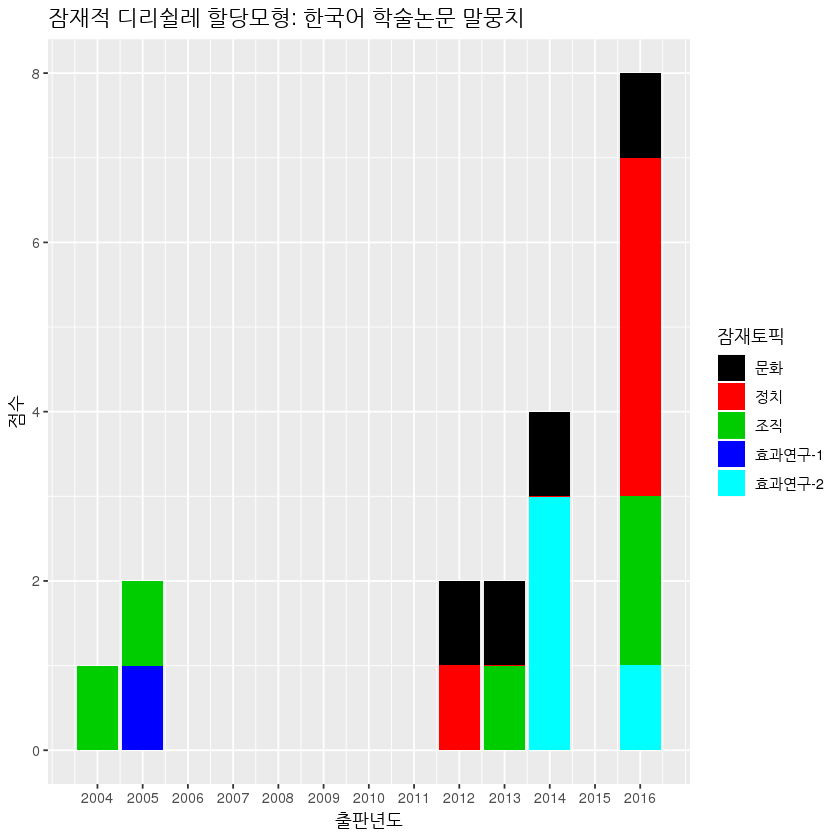

In [25]:
#그래프를 그려보았다. 
topic.by.year <- reshape(topic.by.year, idvar = "pubyear", varying = list(2:6),
                         v.names = "score", direction = "long")
colnames(topic.by.year) <- c('year','topic_i','score')
topic.by.year$topic_i[topic.by.year$topic_i==1] <- '문화'
topic.by.year$topic_i[topic.by.year$topic_i==2] <- '정치'
topic.by.year$topic_i[topic.by.year$topic_i==3] <- '효과연구-1'
topic.by.year$topic_i[topic.by.year$topic_i==4] <- '효과연구-2'
topic.by.year$topic_i[topic.by.year$topic_i==5] <- '조직'
ggplot(data=topic.by.year, aes(x=year, y=score, fill=topic_i)) + 
  geom_bar(stat="identity")+
  scale_x_continuous(breaks=2004:2016,labels=2004:2016)+
  scale_y_continuous(breaks=2*(0:5),labels=2*(0:5))+
  scale_fill_manual(values=1:5)+
  labs(x="출판년도",y="점수",fill='잠재토픽')+
  ggtitle("잠재적 디리쉴레 할당모형: 한국어 학술논문 말뭉치") 

In [26]:
#다음은 CTM이다. 
ctm.out <- CTM(dtm.k,control=list(seed=44),k=5)
terms(ctm.out,12)
#topic1=조직
#topic2=정치 
#topic3=효과연구-2
#topic4=문화
#topic5=효과연구-1

Topic 1,Topic 2,Topic 3,Topic 4,Topic 5
온라인,이용자,프로그램,공동체,커뮤니케이션
이념성향,여론조사,시청자,미디어,포퓰리즘
자율성,조사방법,건강증진,정책연구,민주주의
한국의,트위터,교과과정,인터넷,레토릭
방송사,가중치,정치인,외교전,사회학
이용자,동질성,상호작용,가치지향,엘리트
메르스,통계학,데이터,권위주의,역사학
탈규범,트위터가,말하기,동기와,연구자
가치지향,표본조사,언론학,위키리크스,으로서
감염자,표집방법에,행복감,정권교체,이방인


In [27]:
posterior_ctm <- posterior(ctm.out)
ctm.topics <- data.frame(posterior_ctm$topics)
tempyear <- rownames(ctm.topics)
pubyear <- as.numeric(unlist(str_extract_all(tempyear,"[[:digit:]]{4}")))
topic.by.year <- round(aggregate(as.matrix(ctm.topics)~pubyear,ctm.topics,sum),5)

In [28]:
#결과는 아래와 같다. 
topic.by.year

pubyear,X1,X2,X3,X4,X5
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2004,0.00020,0.98866,0.00021,0.00120,0.00973
2005,0.99575,0.00209,0.00141,0.71180,0.28895
2012,0.98932,0.06144,0.00064,0.91335,0.03524
2013,0.00080,0.98818,0.99339,0.00121,0.01642
2014,1.17113,0.00102,1.66465,0.98721,0.17599
2016,1.99089,0.00313,2.97798,1.99437,1.03363


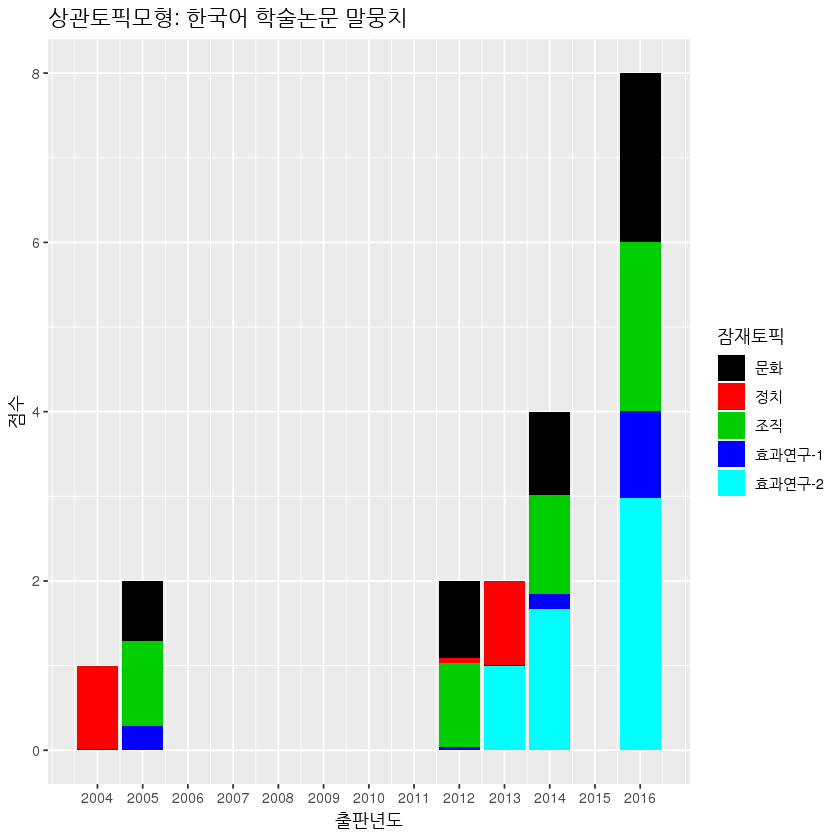

In [29]:
#그래프를 그려보았다. 
topic.by.year <- reshape(topic.by.year, idvar = "pubyear", varying = list(2:6),
                         v.names = "score", direction = "long")
colnames(topic.by.year) <- c('year','topic_i','score')
topic.by.year$topic_i[topic.by.year$topic_i==1] <- '조직'
topic.by.year$topic_i[topic.by.year$topic_i==2] <- '정치'
topic.by.year$topic_i[topic.by.year$topic_i==3] <- '효과연구-2'
topic.by.year$topic_i[topic.by.year$topic_i==4] <- '문화'
topic.by.year$topic_i[topic.by.year$topic_i==5] <- '효과연구-1'
ggplot(data=topic.by.year, aes(x=year, y=score, fill=topic_i)) + 
  geom_bar(stat="identity")+
  scale_x_continuous(breaks=2004:2016,labels=2004:2016)+
  scale_y_continuous(breaks=2*(0:5),labels=2*(0:5))+
  scale_fill_manual(values=1:5)+
  labs(x="출판년도",y="점수",fill='잠재토픽')+
  ggtitle("상관토픽모형: 한국어 학술논문 말뭉치")

In [30]:
#LDA와 CTM의 추정결과의 label을 통일시켜 보자. 
myctmclass <- myldaclass <- rep(NA,19)
myldaclass[as.vector(topics(lda.out))==1] <- '문화'
myldaclass[as.vector(topics(lda.out))==2] <- '정치'
myldaclass[as.vector(topics(lda.out))==3] <- '효과연구-1'
myldaclass[as.vector(topics(lda.out))==4] <- '효과연구-2'
myldaclass[as.vector(topics(lda.out))==5] <- '조직'
myctmclass[as.vector(topics(ctm.out))==1] <- '조직'
myctmclass[as.vector(topics(ctm.out))==2] <- '정치'
myctmclass[as.vector(topics(ctm.out))==3] <- '효과연구-2'
myctmclass[as.vector(topics(ctm.out))==4] <- '문화'
myctmclass[as.vector(topics(ctm.out))==5] <- '효과연구-1'

In [31]:
#교차표를 그리면 아래와 같다. 
as.matrix(table(myldaclass,myctmclass))

            myctmclass
myldaclass   문화 정치 조직 효과연구-1 효과연구-2
  문화          0    0    1          0          3
  정치          3    0    1          0          1
  조직          1    2    1          1          0
  효과연구-1    0    0    1          0          0
  효과연구-2    1    0    1          0          2

In [32]:
#코더간 신뢰도 크리펜도르프의 알파를 구하면 아래와 같다. 
lda.vs.ctm <- as.matrix(rbind(as.factor(myldaclass),as.factor(myctmclass)))
kripp.alpha(lda.vs.ctm)

 Krippendorff's alpha

 Subjects = 19 
   Raters = 2 
    alpha = -0.0667 

In [33]:
# 영문논문초록에 대한 STM 추정
library('tm')
library('stringr')
library('stm') # structuraltopicmodel
my.text.location <- "ymbaek_papers"
mypaper  <- VCorpus(DirSource(my.text.location),
                    readerControl = list(language="en"))

stm v1.3.3 (2018-1-26) successfully loaded. See ?stm for help. 
 Papers, resources, and other materials at structuraltopicmodel.com


In [34]:
#STM에서 사용되는 데이터가 어떤 형태인지 살펴보자. 
dim(gadarian)
colnames(gadarian)
summary(gadarian)

[1] 341   4

[1] "MetaID"              "treatment"           "pid_rep"            
[4] "open.ended.response"

     MetaID    treatment         pid_rep       open.ended.response
 Min.   :0   Min.   :0.0000   Min.   :0.0000   Length:341         
 1st Qu.:0   1st Qu.:0.0000   1st Qu.:0.1667   Class :character   
 Median :0   Median :1.0000   Median :0.5000   Mode  :character   
 Mean   :0   Mean   :0.5015   Mean   :0.5077                      
 3rd Qu.:0   3rd Qu.:1.0000   3rd Qu.:0.8330                      
 Max.   :0   Max.   :1.0000   Max.   :1.0000                      

In [35]:
#list.files() 함수를 이용하면 해당폴더의 화일이름을 추출할 수 있다. 
myfilenames <- list.files(path=my.text.location,
                          pattern=NULL,all.files=TRUE)

In [36]:
#화일이름을 데이터 프레임으로 저장하였다. 
mytxtdf <- data.frame(myfilenames[3:26])

In [37]:
#해당 영문논문의 발간년도를 추출하였다. 
mytxtdf$year <- as.numeric(unlist(
  str_extract_all(mytxtdf[,1],"[[:digit:]]{4}")))
colnames(mytxtdf)[1] <- 'file.name'

In [38]:
#저자가 미국에 체류할 때를 0, 귀국하였을 때를 1로 하는 가변수를 생성한다. 
mytxtdf$return.kor <- ifelse(mytxtdf$year>2011,1,0) 

In [39]:
#논문의 초록을 문자형 자료로 입력하였다. 
mytxtdf$abstract <- NA
for (i in 1:24) {
  mytxtdf$abstract[i] <- as.character(mypaper[[i]][1])
}

In [40]:
#gadarian 데이터와 같은 형식이 된 것을 확인할 수 있다. 
summary(mytxtdf)

      file.name       year        return.kor       abstract        
 p2009a.txt: 1   Min.   :2009   Min.   :0.0000   Length:24         
 p2009b.txt: 1   1st Qu.:2011   1st Qu.:0.0000   Class :character  
 p2010a.txt: 1   Median :2014   Median :1.0000   Mode  :character  
 p2010b.txt: 1   Mean   :2013   Mean   :0.7083                     
 p2010c.txt: 1   3rd Qu.:2014   3rd Qu.:1.0000                     
 p2011a.txt: 1   Max.   :2015   Max.   :1.0000                     
 (Other)   :18                                                     

In [41]:
#텍스트의 사전처리(tm 라이브러리 이용) 
mypreprocess <- textProcessor(mytxtdf$abstract,metadata=mytxtdf)

mypreprocess$documents[1]

Building corpus... 
Converting to Lower Case... 
Removing punctuation... 
Removing stopwords... 
Removing numbers... 
Stemming... 
Creating Output... 


42,43,59,60,63,70,107,108,111,114,⋯,597,627,659,670,685,706,710,713,724,746
1,1,1,1,1,1,1,1,1,3,⋯,1,4,1,1,1,1,1,2,1,1


In [42]:
#DTM 구성함 
myout <- prepDocuments(mypreprocess$documents, 
                       mypreprocess$vocab, mypreprocess$meta,
                       lower.thresh=0)

In [43]:
#STM 추정 (5개의 토픽)
mystm <- stm(myout$documents, myout$vocab, K=5, 
             prevalence =~ return.kor, data=myout$meta,
             seed=2494,init.type="Spectral")

Beginning Spectral Initialization 
	 Calculating the gram matrix...
	 Finding anchor words...
 	.....
	 Recovering initialization...
 	.......
Initialization complete.
........................
Completed E-Step (0 seconds). 
Completed M-Step. 
Completing Iteration 1 (approx. per word bound = -5.852) 
........................
Completed E-Step (0 seconds). 
Completed M-Step. 
Completing Iteration 2 (approx. per word bound = -5.305, relative change = 9.339e-02) 
........................
Completed E-Step (0 seconds). 
Completed M-Step. 
Completing Iteration 3 (approx. per word bound = -5.236, relative change = 1.303e-02) 
........................
Completed E-Step (0 seconds). 
Completed M-Step. 
Completing Iteration 4 (approx. per word bound = -5.227, relative change = 1.690e-03) 
........................
Completed E-Step (0 seconds). 
Completed M-Step. 
Completing Iteration 5 (approx. per word bound = -5.223, relative change = 8.804e-04) 
Topic 1: sns, social, use, relationship, style 
 To

In [44]:
#각 토픽이 발현되는 단어들 점검
labelTopics(mystm,topics=1:5)

Topic 1 Top Words:
 	 Highest Prob: sns, social, use, relationship, style, factor, user 
 	 FREX: style, sns, attach, snss, relationship, factor, social 
 	 Lift: actor, advent, analys, anxious-ambival, assur, athlet, attach 
 	 Score: anxious-ambival, sns, style, attach, snss, factor, outcom 
Topic 2 Top Words:
 	 Highest Prob: privaci, poll, onlin, studi, inform, infring, person 
 	 FREX: privaci, poll, inform, infring, person, optim, opinion 
 	 Lift: aaeopt-inaaf, aaeopt-outaaf, abnotice--consentab, accid, administ, advanc, aftermath 
 	 Score: privaci, augment, poll, inform, person, infring, skeptic 
Topic 3 Top Words:
 	 Highest Prob: model, studi, trust, effect, depress, among, valenc 
 	 FREX: depress, valenc, expenditur, health, older, nonblack, stereotyp 
 	 Lift: captur, commitmentth, expenditur, health, indirect, institut, life 
 	 Score: assum, depress, valenc, trust, expenditur, health, older 
Topic 4 Top Words:
 	 Highest Prob: polit, ambival, studi, among, democrat, whi

In [45]:
#토픽들 사이의 관계
mystm.corr <- topicCorr(mystm)


Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union



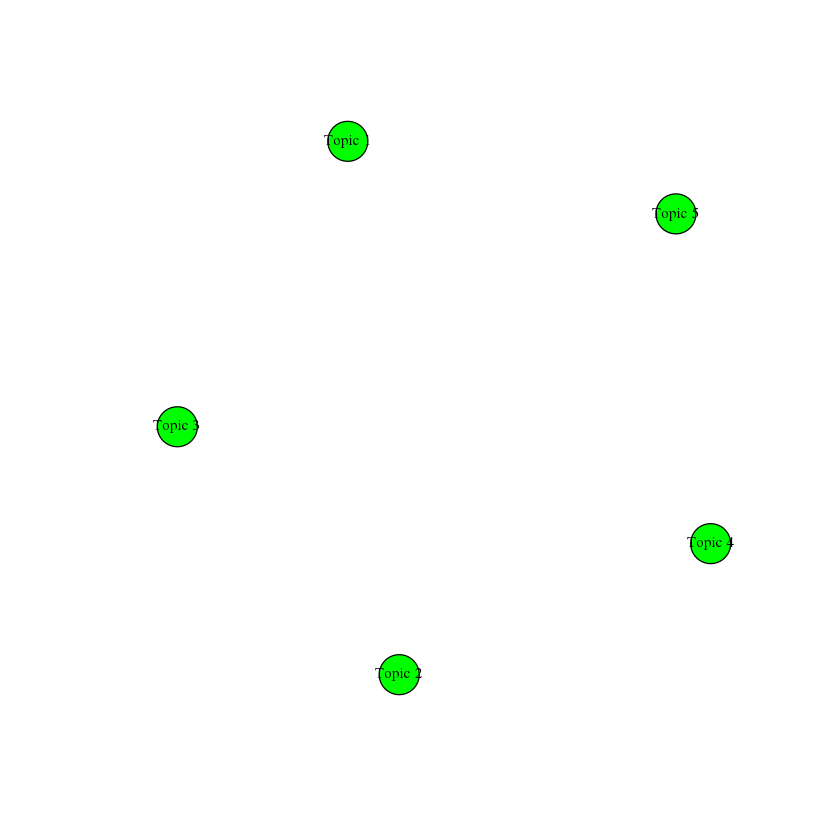

In [46]:
#토픽들 사이의 관계의 시각화
library('igraph')
plot(mystm.corr)

Beginning Spectral Initialization 
	 Calculating the gram matrix...
	 Finding anchor words...
 	..............................
	 Recovering initialization...
 	.......
Initialization complete.
........................
Completed E-Step (0 seconds). 
Completed M-Step. 
Completing Iteration 1 (approx. per word bound = -4.126) 
........................
Completed E-Step (0 seconds). 
Completed M-Step. 
Completing Iteration 2 (approx. per word bound = -4.087, relative change = 9.465e-03) 
........................
Completed E-Step (0 seconds). 
Completed M-Step. 
Completing Iteration 3 (approx. per word bound = -4.086, relative change = 2.811e-04) 
........................
Completed E-Step (0 seconds). 
Completed M-Step. 
Completing Iteration 4 (approx. per word bound = -4.086, relative change = 9.103e-05) 
........................
Completed E-Step (0 seconds). 
Completed M-Step. 
Completing Iteration 5 (approx. per word bound = -4.086, relative change = 1.282e-05) 
Topic 1: sns, style, use, 

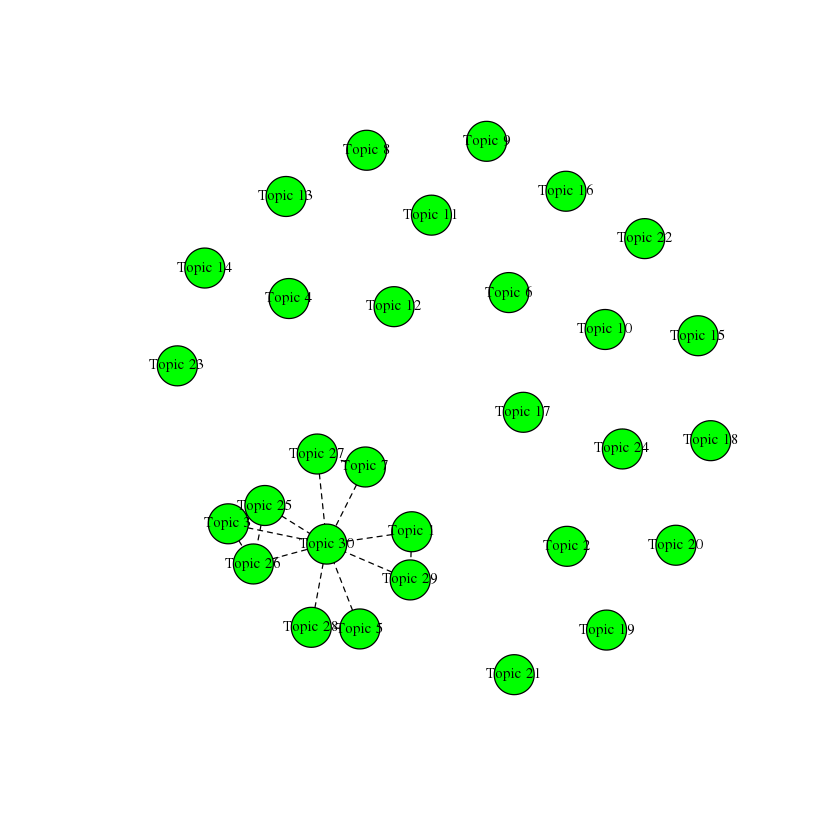

In [47]:
#각주
mytemp <- stm(myout$documents, myout$vocab, K=30, 
              prevalence =~ return.kor, data=myout$meta,
              seed=2494,init.type="Spectral")
mystm.corr <- topicCorr(mytemp)
plot(mystm.corr)


Call:
estimateEffect(formula = c(1:5) ~ return.kor, stmobj = mystm, 
    metadata = mytxtdf)


Topic 1:

Coefficients:
            Estimate Std. Error t value Pr(>|t|)
(Intercept)  0.13973    0.14344   0.974    0.341
return.kor   0.07092    0.17254   0.411    0.685


Topic 2:

Coefficients:
            Estimate Std. Error t value Pr(>|t|)
(Intercept)  0.01034    0.13295   0.078    0.939
return.kor   0.26245    0.16027   1.637    0.116


Topic 3:

Coefficients:
            Estimate Std. Error t value Pr(>|t|)
(Intercept)  0.15529    0.14951   1.039    0.310
return.kor   0.07806    0.17918   0.436    0.667


Topic 4:

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   0.6710     0.1278   5.250 2.88e-05 ***
return.kor   -0.6123     0.1486  -4.122 0.000448 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


Topic 5:

Coefficients:
            Estimate Std. Error t value Pr(>|t|)
(Intercept)  0.01988    0.13077   0.152    0.881
return.kor 

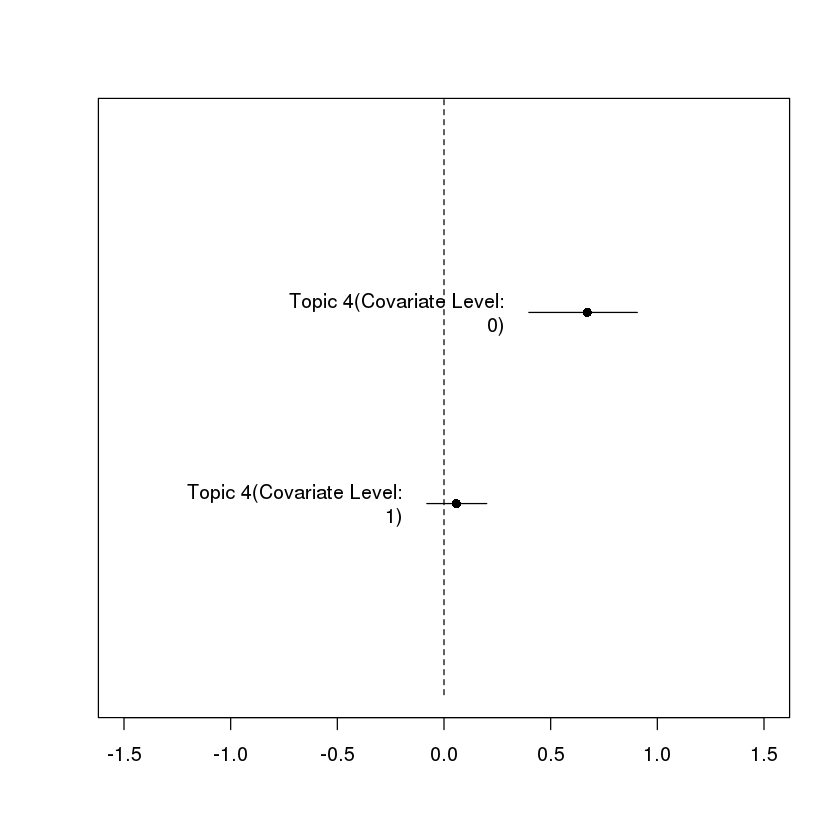

In [48]:
#메타데이터와 토픽발현가능성의 관계 테스트  
myresult <- estimateEffect(c(1:5) ~ return.kor, mystm, mytxtdf)
summary(myresult)

plot(myresult,covariate="return.kor",
     topics=4,model=mystm,xlim=c(-1.5,1.5))